In [1]:
import pandas as pd
import numpy as np

# Get last 31 days of bitcoin prices

In [2]:
df = pd.read_json('http://api.coindesk.com/v1/bpi/historical/close.json?')

In [53]:
df.head()

,bpi,disclaimer,time
2017-05-15,1697.3788,This data was produced from the CoinDesk Bitco...,NaN
2017-05-16,1718.2013,This data was produced from the CoinDesk Bitco...,NaN
2017-05-17,1802.1638,This data was produced from the CoinDesk Bitco...,NaN
2017-05-18,1887.3263,This data was produced from the CoinDesk Bitco...,NaN
2017-05-19,1968.1025,This data was produced from the CoinDesk Bitco...,NaN


In [54]:
btc_prices = df.values[:-2,0]

In [55]:
btc_prices

array([1697.3788, 1718.2013, 1802.1638, 1887.3263, 1968.1025, 2051.735,
       2055.6175, 2139.0275, 2291.4775, 2476.2963, 2357.5038, 2247.4825,
       2106.3075, 2207.5775, 2289.87, 2197.2338, 2330.2338, 2452.1813,
       2517.4088, 2555.6538, 2552.8088, 2736.595, 2914.0825, 2694.2188,
       2825.0313, 2826.7, 2942.345, 3018.545, 2682.595, 2738.9313, 2494.485], dtype=object)

# Lookback is how far back we want include as features. Lookforward is how far into the future we want to predict

In [56]:
lookback = 3
lookforward = 1

# next scale data to be between 0 and 1

In [57]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()
btc_prices = min_max.fit_transform(btc_prices.reshape(-1,1))

# for every value starting at index lookback make that value y and the previous 3 values X

In [58]:
size = len(btc_prices) - lookback - lookforward
X = []
y = []
for i in range(size):
    X.append(btc_prices[i:(i + lookback)])
    y.append(btc_prices[(i + lookback + lookforward - 1)])
X = np.array(X)
y = np.array(y)

# Now each X is the previous 3 prices for each y. X shape will be (samples, timesteps, features). Y shape will be (samples, outputs)

In [59]:
print X.shape
print y.shape

(27, 3, 1)
(27, 1)


# Keep in mind when choosing your lookback and your lookforward that you will not be able to use the first lookback and the last lookforward datapoints. In this example we threw away 4 datapoints

In [60]:
test_size = 7
X_train, X_test = X[:test_size], X[test_size:]
y_train,y_test = y[:test_size], y[test_size:]

# Do not use sklearns train_test_split. the split here must respect time

In [61]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

# Create model with 1 LSTM layer that has 4 neurons. The number of neurons in the dense layer will equal the number of outputs you are wanting to predict. Playing around with the number of layers and neurons is key for success. Also input shape is lookback, features

In [62]:
model = Sequential()
model.add(LSTM( 4, input_shape=(lookback, X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
1s - loss: 0.1133
Epoch 2/5
0s - loss: 0.1038
Epoch 3/5
0s - loss: 0.0950
Epoch 4/5
0s - loss: 0.0860
Epoch 5/5
0s - loss: 0.0794


In [63]:
preds = model.predict(X_test)

# Plot to see if you model looks reasonable. If it does write a backtesting function to see if it would have made you money

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
y_test = min_max.inverse_transform(y_test)
preds = min_max.inverse_transform(preds)

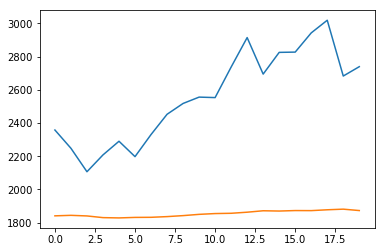

In [66]:
plt.plot(y_test)
plt.plot(preds)
plt.legend()

# In this case there was not enough data for a LSTM really so the prediction just looks awful. 